In [ ]:
!pip install timm --quiet

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR


In [ ]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/images"  # Update this path if needed

# Transformations for grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),                # Resize for PVT compatibility
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))          # Normalize images
])

# Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class names to verify loading
class_names = full_dataset.classes
print("Classes:", class_names)


Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
# Load the Pyramid Vision Transformer model
model = timm.create_model('pvt_v2_b0', pretrained=True)  # 'pvt_v2_b0' is a lightweight PVT variant

# Modify the final classification layer to match the number of classes
num_classes = 4
in_features = model.get_classifier().in_features
model.head = nn.Linear(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for metrics calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc, precision, recall, f1

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return epoch_loss, epoch_acc,precision, recall, f1
# Tracking metrics for visualization
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [ ]:
# Training loop
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")

    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)


    scheduler.step()  # Adjust learning rate


Epoch 1/10


100%|██████████| 312/312 [06:52<00:00,  1.32s/it]


Training Loss: 0.8031, Accuracy: 69.80%, Precision: 0.66, Recall: 0.70, F1 Score: 0.65
Validation Loss: 0.4059, Accuracy: 87.15%, Precision: 0.86, Recall: 0.87, F1 Score: 0.86

Epoch 2/10


100%|██████████| 312/312 [02:11<00:00,  2.37it/s]

Training Loss: 0.3423, Accuracy: 88.00%, Precision: 0.87, Recall: 0.88, F1 Score: 0.87


Validation Loss: 0.2677, Accuracy: 91.41%, Precision: 0.91, Recall: 0.91, F1 Score: 0.91

Epoch 3/10


100%|██████████| 312/312 [02:15<00:00,  2.30it/s]

Training Loss: 0.1852, Accuracy: 93.94%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


Validation Loss: 0.2359, Accuracy: 92.97%, Precision: 0.94, Recall: 0.93, F1 Score: 0.93

Epoch 4/10


100%|██████████| 312/312 [02:13<00:00,  2.33it/s]

Training Loss: 0.1404, Accuracy: 95.49%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


Validation Loss: 0.1590, Accuracy: 94.78%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95

Epoch 5/10


100%|██████████| 312/312 [02:14<00:00,  2.32it/s]

Training Loss: 0.1087, Accuracy: 96.60%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97


Validation Loss: 0.1216, Accuracy: 95.74%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96

Epoch 6/10


100%|██████████| 312/312 [02:12<00:00,  2.36it/s]

Training Loss: 0.0247, Accuracy: 99.38%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation Loss: 0.0216, Accuracy: 99.48%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch 7/10


100%|██████████| 312/312 [02:08<00:00,  2.43it/s]

Training Loss: 0.0068, Accuracy: 99.90%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation Loss: 0.0185, Accuracy: 99.64%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00

Epoch 8/10


100%|██████████| 312/312 [02:10<00:00,  2.39it/s]

Training Loss: 0.0106, Accuracy: 99.76%, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


Validation Loss: 0.0485, Accuracy: 98.84%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch 9/10


100%|██████████| 312/312 [02:11<00:00,  2.38it/s]

Training Loss: 0.0464, Accuracy: 98.55%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


Validation Loss: 0.0286, Accuracy: 99.28%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99

Epoch 10/10


100%|██████████| 312/312 [02:20<00:00,  2.22it/s]


Training Loss: 0.0224, Accuracy: 99.37%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99
Validation Loss: 0.0346, Accuracy: 99.08%, Precision: 0.99, Recall: 0.99, F1 Score: 0.99



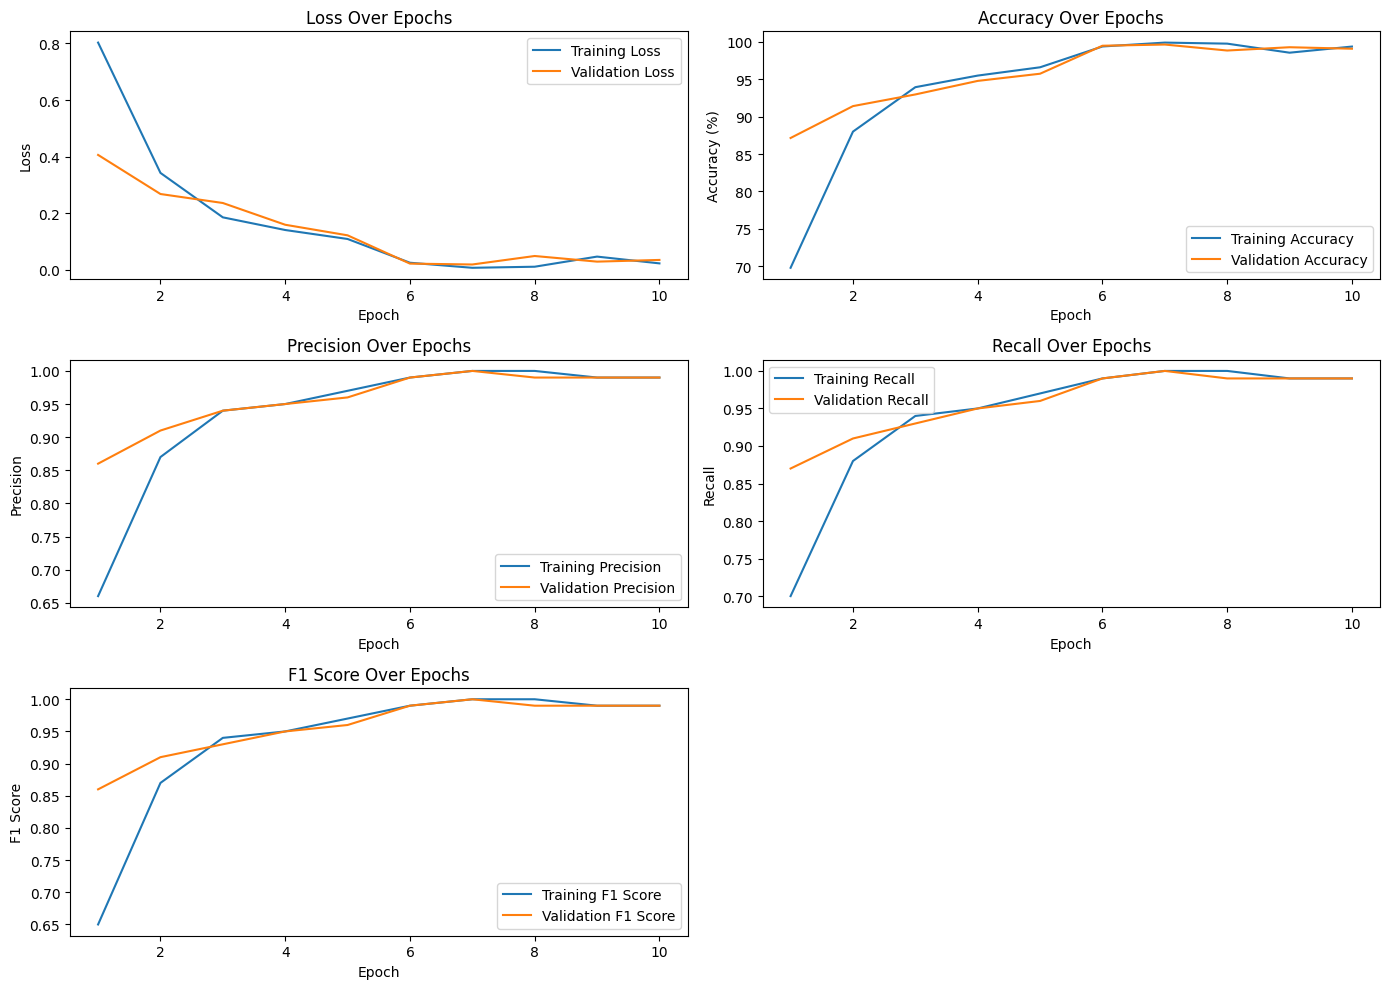

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these example data with your actual recorded values from the training loop
epochs = np.arange(1, 11)
train_losses = [0.8031, 0.3423, 0.1852, 0.1404, 0.1087, 0.0247, 0.0068, 0.0106, 0.0464, 0.0224]
val_losses = [0.4059, 0.2677, 0.2359, 0.1590, 0.1216, 0.0216, 0.0185, 0.0485, 0.0286, 0.0346]
train_accuracies = [69.8, 88.0, 93.94, 95.49, 96.6, 99.38, 99.9, 99.76, 98.55, 99.37]
val_accuracies = [87.15, 91.41, 92.97, 94.78, 95.74, 99.48, 99.64, 98.84, 99.28, 99.08]
train_precisions = [0.66, 0.87, 0.94, 0.95, 0.97, 0.99, 1.00, 1.00, 0.99, 0.99]
val_precisions = [0.86, 0.91, 0.94, 0.95, 0.96, 0.99, 1.00, 0.99, 0.99, 0.99]
train_recalls = [0.70, 0.88, 0.94, 0.95, 0.97, 0.99, 1.00, 1.00, 0.99, 0.99]
val_recalls = [0.87, 0.91, 0.93, 0.95, 0.96, 0.99, 1.00, 0.99, 0.99, 0.99]
train_f1s = [0.65, 0.87, 0.94, 0.95, 0.97, 0.99, 1.00, 1.00, 0.99, 0.99]
val_f1s = [0.86, 0.91, 0.93, 0.95, 0.96, 0.99, 1.00, 0.99, 0.99, 0.99]

# Plot metrics
plt.figure(figsize=(14, 10))

# Plot Loss
plt.subplot(3, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(3, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plot Precision
plt.subplot(3, 2, 3)
plt.plot(epochs, train_precisions, label='Training Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Over Epochs')
plt.legend()

# Plot Recall
plt.subplot(3, 2, 4)
plt.plot(epochs, train_recalls, label='Training Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Over Epochs')
plt.legend()

# Plot F1 Score
plt.subplot(3, 2, 5)
plt.plot(epochs, train_f1s, label='Training F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()
